## License 

Copyright 2017 - 2019 Patrick Hall, Navdeep Gill, and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Global Shapley Values and Residual Analysis

#### Start H2O cluster


The `os` commands below check whether this notebook is being run on the Aquarium platform. 

In [1]:
import os

startup = '/home/h2o/bin/aquarium_startup'
if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
    !sleep 5
else:
    local_url = 'http://localhost:54321'
    aquarium = False

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks.

In [2]:
# h2o Python API with specific classes
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

pd.options.display.max_columns = 999 # enable display of all columns in notebook

# plotting functionality
import matplotlib.pyplot as plt
import seaborn as sns

import shap # Python Shapley value package

# display plots in notebook
%matplotlib inline

# ignore irrelevant warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Start h2o
H2o is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 2, but the server still needs to be started.

>The parameters used in `h2o.init` will depend on your specific environment. Regardless of how H2O is installed, if you start a cluster, you will need to ensure that it is shut down when you are done.

In [3]:
h2o.init(url=local_url, max_mem_size='2G')
h2o.remove_all()    # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321/h2o . connected.


H2O cluster uptime:,07 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 13 days
H2O cluster name:,h2o
H2O cluster total nodes:,1
H2O cluster free memory:,2.167 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## Load, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

The shorthand name y is assigned to the prediction target. X is assigned to all other input variables in the credit card default data except the row indentifier, ID, and the demographic variables are dropped from the analysis.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean

In [4]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
The shorthand name y is assigned to the prediction target. X is assigned to all other input variables in the credit card default data except the row indentifier, ID.

In [5]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID', 'AGE', 'EDUCATION', 'SEX', 'MARRIAGE', 'LIMIT_BAL']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. These character values can be used directly in h2o decision tree models, and the function returns the original Pandas DataFrame as an h2o object, an H2OFrame. H2o models cannot run on Pandas DataFrames. They require H2OFrames.

In [6]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption (-2)', -1:'pay duly (-1)', 0:'use of revolving credit (0)', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable

In [7]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics

In [8]:
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666667,,,,35.48549999999987,,,,,,,51223.330899999935,49179.0751666667,47013.15479999978,43262.94896666669,40311.4009666666,38871.76040000009,5663.580500000006,5921.1635,5225.681500000008,4826.076866666684,4799.3876333333155,5215.502566666679,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720246,,,,9.217904068090172,,,,,,,73635.86057552964,71173.76878252838,69349.38742703681,64332.856133916415,60797.1557702648,59554.10753674574,16563.280354025763,23040.87040205722,17606.961469803107,15666.159744031986,15278.305679144814,17777.465775435325,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly (-1),pay duly (-1),no consumption (-2),no consumption (-2),3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly (-1),2 month delay,use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## Train an H2O GBM classifier

#### Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [9]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Train h2o an unconstrained GBM classifier

In [10]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     seed=12345)            # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.4f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.7715


#### Display Shapley variable importance
Shapley values are a locally-accurate and globally consistent variable importance metric. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be calculated and aggregated below to get a more holistic and consisent measurement for the global importance of each input variable.

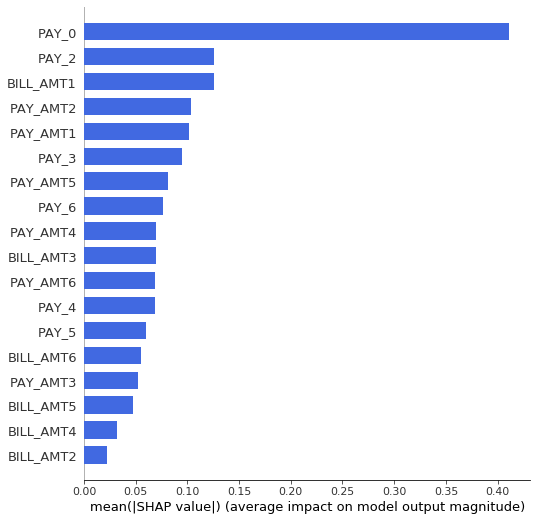

In [11]:
contributions = model.predict_contributions(test)
contributions_matrix = contributions.as_data_frame().as_matrix()
shap_values = contributions_matrix[:,:-1]
shap.summary_plot(shap_values, X, plot_type='bar', color='royalblue')

## Conduct residual analysis to debug model
Residuals refer to the difference between the recorded value of a dependent variable and the predicted value of a dependent variable for every row in a data set. Plotting the residual values against the predicted values is a time-honored model assessment technique and a great way to see all your modeling results in two dimensions.

#### Bind model predictions onto test data 
To calculate the residuals for our GBM model, first the model predictions are merged onto the test set. The test data is used here to see how the model behaves on holdout data, which should be closer to its behavior on new data than analyzing residuals for the training inputs and predictions.

In [12]:
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = model.predict(test).drop(['predict', 'p0'])
preds1.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Calculate deviance residuals for binomial classification
For binomial classification, deviance residuals are related to the logloss cost function. Like analyzing $y - \hat{y}$ for linear regression, these residuals are related to the quantities that the GBM sought to minimize. Deviance residual values are calculated by applying the formula in the cell directly below.

In [13]:
# use Pandas for adding columns and plotting
test_yhat = test_yhat.as_data_frame()
test_yhat['s'] = 1
test_yhat.loc[test_yhat['DEFAULT_NEXT_MONTH'] == 0, 's'] = -1
test_yhat['r_DEFAULT_NEXT_MONTH'] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
                                                                 ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

#### Sort data by residuals and display data and residuals

In [14]:
test_yhat = test_yhat.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
test_yhat

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,6933,500000,male,graduate school,single,37,pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),4331,60446,30592,154167,13410,25426,60446,30594,150843,163881,25426,39526,1,0.023263,2.742588
1,523,360000,male,graduate school,single,28,pay duly (-1),pay duly (-1),pay duly (-1),use of revolving credit (0),use of revolving credit (0),pay duly (-1),1210,820,64644,125984,106584,125557,390,75720,62520,17000,132200,167000,1,0.024423,2.724784
2,25692,330000,female,graduate school,single,42,no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),565,20650,15360,0,12923,1816,20650,15360,0,12923,1816,17050,1,0.030037,2.647768
3,11090,240000,male,university,married,41,use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),22165,21292,16469,13737,9071,177268,7002,3002,5002,3009,177004,5452,1,0.030458,2.642505
4,11745,220000,male,graduate school,single,51,pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),20730,-270,53895,-105,20895,20835,0,54165,0,21000,20940,33460,1,0.031113,2.634431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8935,565,390000,female,graduate school,single,45,2 month delay,2 month delay,2 month delay,pay duly (-1),2 month delay,2 month delay,834,155,-1690,4240,3346,2698,1,1693,6940,7,1230,3,0,0.880548,-2.061475
8936,14589,280000,male,graduate school,married,50,3 month delay,5 month delay,4 month delay,3 month delay,2 month delay,use of revolving credit (0),327918,321476,314931,176439,154010,134334,0,0,500,0,6267,2257,0,0.900238,-2.147077
8937,29505,20000,male,university,married,40,1 month delay,2 month delay,3 month delay,2 month delay,3 month delay,3 month delay,14829,17267,16706,18694,19049,18459,3000,0,2560,955,0,661,0,0.901251,-2.151827
8938,9672,170000,male,graduate school,single,48,2 month delay,2 month delay,7 month delay,7 month delay,7 month delay,7 month delay,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,0,0.905012,-2.169794


#### Plot residuals by most important input variable 
Plotting residuals is a model debugging and diagnostic tool that enables users to see modeling results, and any anomolies, in a single two-dimensional plot. Here the green points represent customers who defaulted, and the blue points represent customers who did not. A few potential outliers are visible. There appear to be several cases in the test data with relatively large negative residuals. Understanding and addressing the factors that cause these outliers could lead to a more acccurate model.

Residuals can also be plotted for important input variables to understand how the values of a single input variable affect prediction errors. When plotted by PAY_0, the residuals confirm that the GBM is struggling to accurately predict cases where default status is not correlated with recent payment behavior in an obvious way. The residual plots for values of PAY_0 indicating timely payment behavior (e.g., use of revolving credit, pay duly, and no consumption) generally display the highest positive residuals and relatively small negative residuals. Residuals for the other values of PAY_0, those that represent late recent payments, tend to show large negative residuals and relatively small positive residuals.

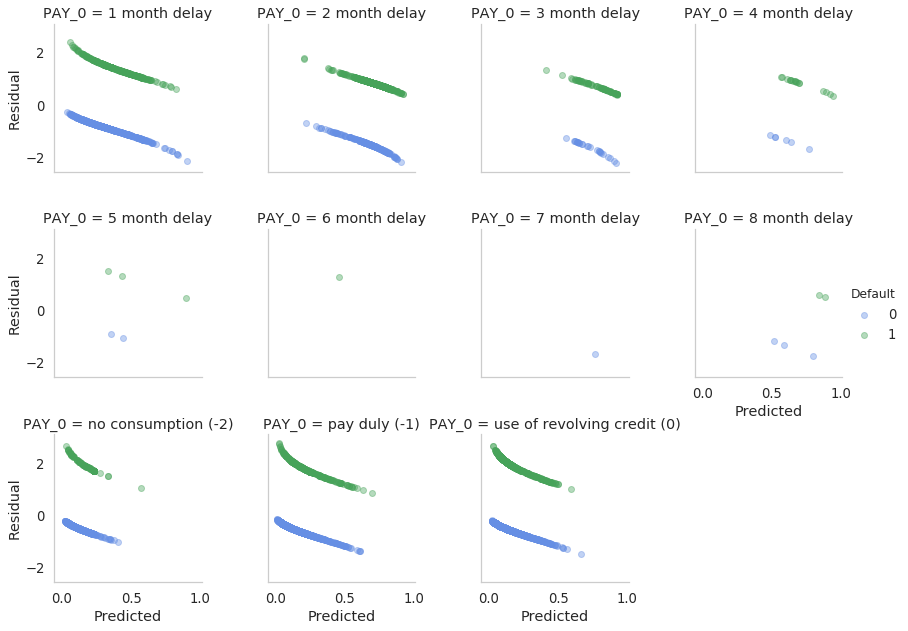

In [15]:
# sort for better organization in plot
sorted_ = test_yhat.sort_values(by='PAY_0')
sorted_.rename(columns={yhat: 'Predicted', 
                        'r_DEFAULT_NEXT_MONTH': 'Residual',
                        y: 'Default'}, 
               inplace=True)

# use Seaborn FacetGrid for convenience
sns.set(font_scale=1.2) 
sns.set_style('whitegrid', {'axes.grid': False})
sns.set_palette((sns.diverging_palette(255, 133, l=60, n=2, center='dark')))
g = sns.FacetGrid(sorted_, col='PAY_0', hue='Default', col_wrap=4)
_ = g.map(plt.scatter, 'Predicted', 'Residual', alpha=0.4)
_ = g.add_legend() 

#### Shutdown H2O
After using h2o, it's typically best to shut it down. However, before doing so, users should ensure that they have saved any h2o data structures, such as models and H2OFrames, or scoring artifacts, such as POJOs and MOJOs.

In [16]:
# be careful, this can erase your work!
h2o.cluster().shutdown()

H2O session _sid_922e closed.


**Conclusion**: The unconstrained GBM in this notebook makes predictable mistakes, that are plainly obvious after applying straightforward explanation and model debugging techniques. This model is explainable, but not trustworthy. 